In [66]:
import os, time
from scipy import stats
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
%matplotlib inline

from IPython.display import display, HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [67]:
# Create timestamp to show when this summary was run
print 'Summary run: ' + time.strftime("%a, %d %b %Y %H:%M")

Summary run: Thu, 21 May 2020 10:58


In [68]:
base_path = os.getcwd().split('\\scripts')[0]
relative_path = '../../../outputs'
pd.options.display.float_format = '{:0,.2f}'.format
format_percent = "{:,.2%}".format

# Work From Home

In [69]:
df = pd.read_csv(os.path.join(relative_path,'agg','work_home_location.csv'))
parcel_geog = pd.read_sql_table('parcel_2018_geography', 'sqlite:///'+os.path.join(base_path,r'inputs\db\soundcast_inputs.db')) 
df = df.merge(parcel_geog, left_on='pwpcl',right_on='ParcelID')
df = df.merge(parcel_geog, left_on='hhparcel',right_on='ParcelID', suffixes=['_work','_home'])
# Get work-from-home people
df_wfh = df[df['hhparcel'] == df['pwpcl']]

_df = df_wfh.groupby('CountyName_work').sum()[['psexpfac']]
_df.loc['Total',:] = _df.sum(axis=0)
_df = _df.reset_index()

# Survey
df_survey = pd.read_csv(os.path.join(relative_path,'agg\survey','work_home_location.csv'))
# df_survey
df_survey = df_survey.merge(parcel_geog, left_on='pwpcl',right_on='ParcelID')
df_survey = df_survey.merge(parcel_geog, left_on='hhparcel',right_on='ParcelID', suffixes=['_work','_home'])
df_survey_wfh = df_survey[df_survey['hhparcel'] == df_survey['pwpcl']]

_df_survey = df_survey_wfh.groupby('CountyName_work').sum()[['psexpfac']]
_df_survey.loc['Total',:] = _df_survey.sum(axis=0)
_df_survey = _df_survey.reset_index()

dfmerge = _df.merge(_df_survey, on='CountyName_work', suffixes=['_model','_survey'])
dfmerge.rename(columns={'CountyName_work': 'County', 'psexpfac_model': 'model', 'psexpfac_survey': 'survey'},
              inplace=True)
dfmerge['diff'] = dfmerge['survey']-dfmerge['model']
dfmerge['% diff'] = dfmerge['diff']/dfmerge['survey']
dfmerge[['model','survey','diff']] = dfmerge[['model','survey','diff']].astype('int')
dfmerge

,County,model,survey,diff,% diff
0,King,51307,82750,31443,0.38
1,Kitsap,8261,9446,1185,0.13
2,Pierce,20999,22401,1402,0.06
3,Snohomish,21915,25771,3856,0.15
4,Total,102482,140369,37887,0.27


# Tour Rate for Work-at-Home Workers

In [70]:
# df = pd.read_csv(os.path.join(relative_path,'agg','work_home_location.csv'))
# df_wfh = df[df['hhparcel'] == df['pwpcl']]
# df_wfh['psexpfac'].sum()

In [71]:
df = pd.read_csv(os.path.join(relative_path,'agg','work_home_location.csv'))
wfh_total = df[df['pwpcl'] == df['hhparcel']]['psexpfac'].sum()

df = pd.read_csv(os.path.join(relative_path,'agg','survey','work_home_location.csv'))
wfh_total_survey = df[df['pwpcl'] == df['hhparcel']]['psexpfac'].sum()

In [72]:
df = pd.read_csv(os.path.join(relative_path,'agg','work_from_home_tours.csv'))
tours_df = df[df['hhparcel'] == df['pwpcl']].groupby('pdpurp').sum()[['toexpfac']]
tours_df = tours_df.reset_index()

df_survey_tours = pd.read_csv(os.path.join(relative_path,'agg','survey','work_from_home_tours.csv'))
tours_df_survey = df_survey_tours[df_survey_tours['hhparcel'] == df_survey_tours['pwpcl']].groupby('pdpurp').sum()[['toexpfac']]
tours_df_survey = tours_df_survey.reset_index()

In [83]:
df_merge = tours_df.merge(tours_df_survey, on='pdpurp', suffixes=['_model','_survey'])
df_merge['tour_rate_model'] = df_merge['toexpfac_model']/wfh_total
df_merge['tour_rate_survey'] = df_merge['toexpfac_survey']/wfh_total_survey
df_merge[['pdpurp','tour_rate_model','tour_rate_survey']]
df_merge['toexpfac_survey'] = df_merge['toexpfac_survey'].astype('int')
df_merge

,pdpurp,toexpfac_model,toexpfac_survey,tour_rate_model,tour_rate_survey
0,Escort,15835,11244,0.1545,0.0801
1,Meal,5363,8125,0.0523,0.0579
2,Personal Business,15830,11365,0.1545,0.0810
3,School,5468,660,0.0534,0.0047
4,Shop,18913,29214,0.1845,0.2081
5,Social,33880,34826,0.3306,0.2481
6,Work,66563,8785,0.6495,0.0626


# Commute Distance

In [74]:
df = pd.read_csv(os.path.join(relative_path,'agg','tour_distance.csv'))
df = df[df['dpurp'] == 'Work']

pd.options.display.float_format = '{:0,.4f}'.format
_df = df.groupby('travdist_bin').sum()[['trexpfac']].reset_index()

_df['percent'] = _df['trexpfac']/_df['trexpfac'].sum()
_df['cumulative_percent'] = _df['percent'].cumsum()

# remove records that are outside 99% of records
_df = _df[_df['cumulative_percent'] <= 0.99]

In [75]:
df_survey = pd.read_csv(os.path.join(relative_path,'agg/survey','tour_distance.csv'))
df_survey = df_survey[df_survey['dpurp'] == 'Work']

_df_survey = df_survey.groupby('travdist_bin').sum()[['trexpfac']].reset_index()

_df_survey['percent'] = _df_survey['trexpfac']/_df_survey['trexpfac'].sum()
_df_survey['cumulative_percent'] = _df_survey['percent'].cumsum()

# remove records that are outside 99% of records
_df_survey = _df_survey[_df_survey['cumulative_percent'] <= 0.99]

In [76]:
_df_merged = _df.merge(_df_survey, on='travdist_bin', suffixes=['_model','_survey'])
# _df_merged

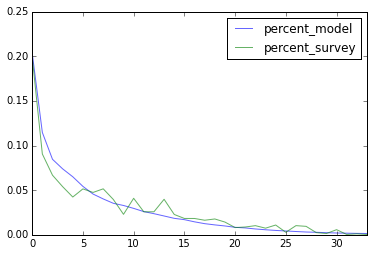

In [77]:
_df_merged[['percent_model','percent_survey']].plot(alpha=0.6)

# _df[['trexpfac']].plot(kind='bar')

# Distance by Mode

In [78]:
df = pd.read_csv(os.path.join(relative_path,'agg','tour_distance.csv'))

In [79]:
df.head()

,dpurp,mode,pptyp,travdist_bin,trexpfac
0,Change Mode Inserted Purpose,HOV2,Full-Time Worker,0,232
1,Change Mode Inserted Purpose,HOV2,Full-Time Worker,1,240
2,Change Mode Inserted Purpose,HOV2,Full-Time Worker,2,188
3,Change Mode Inserted Purpose,HOV2,Full-Time Worker,3,179
4,Change Mode Inserted Purpose,HOV2,Full-Time Worker,4,173


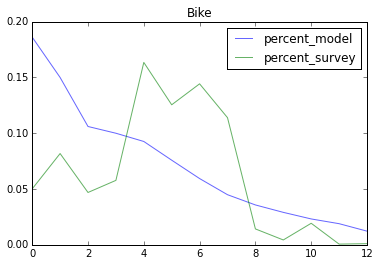

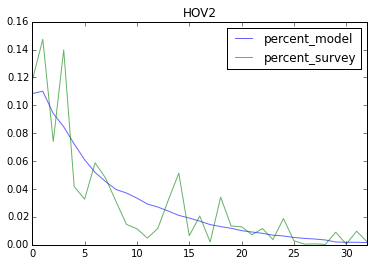

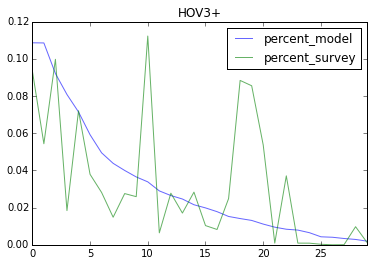

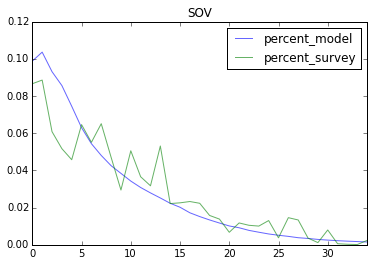

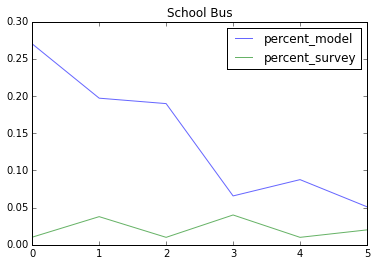

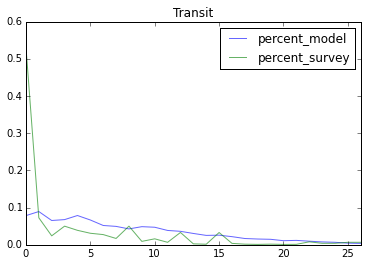

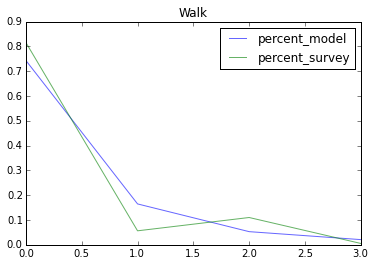

In [80]:
df = pd.read_csv(os.path.join(relative_path,'agg','tour_distance.csv'))
df = df[df['dpurp'] == 'Work']

for mode in df['mode'].unique():
#     print(mode)
    _df = df[df['mode'] == mode]
    
    _df = _df.groupby('travdist_bin').sum()[['trexpfac']].reset_index()

    _df['percent'] = _df['trexpfac']/_df['trexpfac'].sum()
    _df['cumulative_percent'] = _df['percent'].cumsum()

    # remove records that are outside 99% of records
    _df = _df[_df['cumulative_percent'] <= 0.99]
    
    _df_survey = df_survey[df_survey['mode'] == mode]
    _df_survey = _df_survey.groupby('travdist_bin').sum()[['trexpfac']].reset_index()

    _df_survey['percent'] = _df_survey['trexpfac']/_df_survey['trexpfac'].sum()
    _df_survey['cumulative_percent'] = _df_survey['percent'].cumsum()

    # remove records that are outside 99% of records
    _df_survey = _df_survey[_df_survey['cumulative_percent'] <= 0.99]
    
    _df_merged = _df.merge(_df_survey, on='travdist_bin', suffixes=['_model','_survey'])
    _df_merged[['percent_model','percent_survey']].plot(alpha=0.6, title=mode)
    
    
# pd.options.display.float_format = '{:0,.4f}'.format
# _df = df.groupby('travdist_bin').sum()[['trexpfac']].reset_index()

# _df['percent'] = _df['trexpfac']/_df['trexpfac'].sum()
# _df['cumulative_percent'] = _df['percent'].cumsum()

# # remove records that are outside 99% of records
# _df = _df[_df['cumulative_percent'] <= 0.99]